# Generative Adversarial Networks

In this tutorial, we will cover a simple example of a Generative Adversarial Network (GAN), where the goal is to create syntheic digits images from uniform random noise input.

The learning goals of this tutorial are:
- Introduce GANs using a simple example;
- Illustrate how to define a simple GAN using TensorFlow and Keras.


In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as  np
import tensorflow as tf

# Specific to my computer
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def generator(input_dim = (100,), dim = 7, nchannels = 1,  dropout = 0.25, kshape = (5,5)):
    random_input = tf.keras.layers.Input(input_dim)
    x1 = tf.keras.layers.Dense(dim*dim*nchannels, activation = 'relu')(random_input)
    x2 = tf.keras.layers.BatchNormalization(momentum = 0.9)(x1)
    x3 = tf.keras.layers.Reshape((dim,dim,nchannels))(x2)
    x4 = tf.keras.layers.Dropout(dropout)(x3)
    x5 = tf.keras.layers.UpSampling2D((2,2))(x4)
    x6 = tf.keras.layers.Conv2D(200, kshape, padding='same', activation = 'relu')(x5)
    x7 = tf.keras.layers.BatchNormalization(momentum=0.9)(x6)
    x8 = tf.keras.layers.Conv2D(200, kshape, padding='same', activation = 'relu')(x7)
    x9 = tf.keras.layers.BatchNormalization(momentum=0.9)(x8)    
    x10 = tf.keras.layers.UpSampling2D((2,2))(x9)
    x11 = tf.keras.layers.Conv2D(100, kshape, padding='same', activation = 'relu')(x10)
    x12 = tf.keras.layers.BatchNormalization(momentum=0.9)(x11)
    x13 = tf.keras.layers.Conv2D(100, kshape, padding='same', activation = 'relu')(x12)
    x14 = tf.keras.layers.BatchNormalization(momentum=0.9)(x13)
    
    x15 = tf.keras.layers.Conv2D(50, kshape, padding='same', activation = 'relu')(x14)
    x16 = tf.keras.layers.BatchNormalization(momentum=0.9)(x15)
    x17 = tf.keras.layers.Conv2D(30, kshape, padding='same', activation = 'relu')(x16)
    x18 = tf.keras.layers.Conv2D(1, kshape, padding='same', activation = 'sigmoid')(x17)
    model = tf.keras.models.Model(inputs=random_input, outputs=x18)
    return model

def discriminator(ishape = (28,28,1), dropout = 0.25, kshape = (3,3)):
    model_input = tf.keras.layers.Input(shape = ishape)
    x1 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(model_input)
    x2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(x1)
    x3 = tf.keras.layers.Dropout(0.25)(x2)
    x4 = tf.keras.layers.MaxPool2D((2,2))(x3)
    x5 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(x4)
    x6 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(x5)
    x7 = tf.keras.layers.Dropout(0.25)(x6)
    flat = tf.keras.layers.Flatten()(x7)
    out = tf.keras.layers.Dense(1, activation = 'sigmoid')(flat)
    
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    return model    

In [3]:
# Defining the discriminator model
optimizer_d = tf.keras.optimizers.RMSprop(lr = 0.0008, clipvalue = 1.0, decay = 6e-8)
discriminator_model = discriminator()
discriminator_model.compile(loss = "binary_crossentropy", optimizer = optimizer_d, metrics = ["accuracy"])

In [4]:
optimizer_gan= tf.keras.optimizers.RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 3e-8)
generator_model = generator()
random_input = tf.keras.layers.Input((100,))
discriminator_model.trainable = False
out = discriminator_model(generator_model(random_input))
gan_model = tf.keras.models.Model(inputs = random_input, outputs = out)
gan_model.compile(loss = "binary_crossentropy", optimizer = optimizer_gan, metrics = ["accuracy"])

In [5]:
gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         1926676   
_________________________________________________________________
model (Model)                (None, 1)                 164689    
Total params: 2,091,365
Trainable params: 1,925,278
Non-trainable params: 166,087
_________________________________________________________________


In [6]:
generator_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                4949      
_________________________________________________________________
batch_normalization (BatchNo (None, 49)                196       
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 1)           0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 200)       5200

In [7]:
discriminator_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 48)        480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 48)        20784     
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 48)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 96)        41568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 96)        83040 

In [8]:
(X_dev,_),_ = tf.keras.datasets.mnist.load_data()
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
X_dev = X_dev/255
X_dev = X_dev[:,:,:,np.newaxis]
batch_size = 96

In [9]:
a_loss_history = []
d_loss_history = []


for ii in range(20):
    true_images = X_dev[np.random.randint(0,X_dev.shape[0], size = batch_size)]
    noise = np.random.uniform(-1,1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise)
    x = np.concatenate((true_images,fake_images), axis = 0)
    y = np.ones([2*batch_size,1])
    y[batch_size:,:] = 0
    discriminator_model.train_on_batch(x,y)
for ii in range(20000):
    true_images = X_dev[np.random.randint(0,X_dev.shape[0], size = batch_size)]
    noise = np.random.uniform(-1,1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise)
    x = np.concatenate((true_images,fake_images), axis = 0)
    y = np.ones([2*batch_size,1])
    y[batch_size:,:] = 0
    d_loss_history.append(discriminator_model.train_on_batch(x,y))
    y = np.ones([batch_size,1])
    noise = np.random.uniform(-1,1, size = [batch_size, 100])
    a_loss_history.append(gan_model.train_on_batch(noise,y))

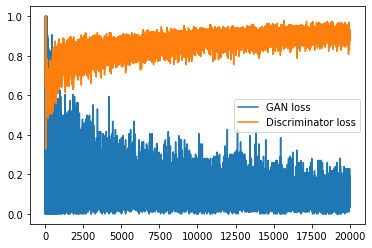

In [12]:
a_loss_history = np.array(a_loss_history)
d_loss_history = np.array(d_loss_history)
plt.plot()
plt.plot(a_loss_history[:,1], label = "GAN loss")
plt.plot(d_loss_history[:,1], label = "Discriminator loss")
plt.legend()
plt.show()

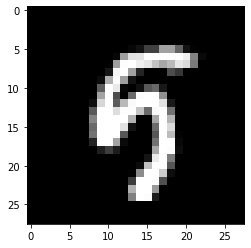

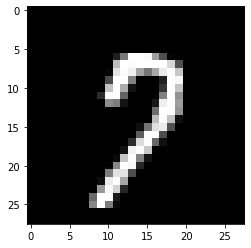

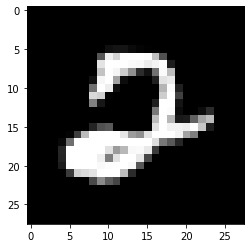

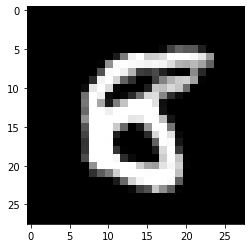

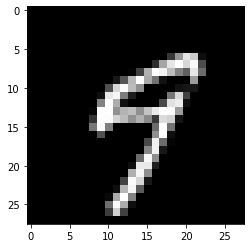

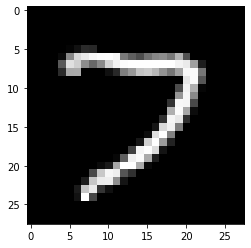

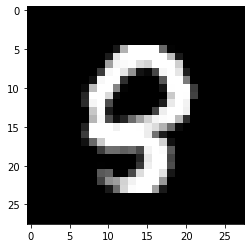

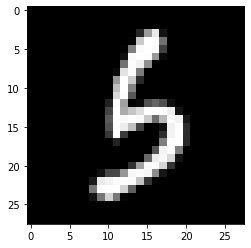

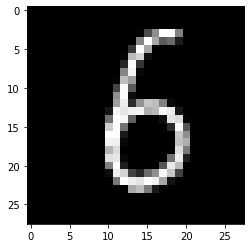

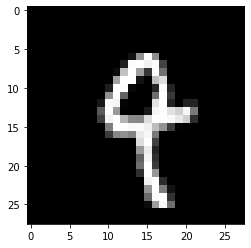

In [13]:
noise = np.random.uniform(-1,1, size = [10, 100])
fake_images = generator_model.predict(noise)
for ii in range(10):
    plt.figure()
    plt.imshow(fake_images[ii,:,:,0], cmap = "gray")
    plt.show()